# Siamese Neural Networks
Recognize images of icebergs from images of ships. 
These images were taken from space with a Sentinel-4 satellite. The goal was to create the most accurate neural network to differentiate them. However, neural networks usually only work well with A LOT of data, and I constrained you guys to 1000 examples to train on. That seems like a lot, but a CONVENTIONAL neural network needs more data. However, we are going to make a special kind of neural network: *Siamese Network*. This special network is used for face recognition and few-shot learning(learning from few examples). Let's get started by importing the usual liraries:

In [0]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D,Activation, Dropout
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import Adam
from skimage.io import imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

In [0]:
from sklearn.utils import shuffle

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

## Load the Data


In [41]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [42]:
npz = np.load('/content/drive/My Drive/Labs/Residency10/External/input_data.npz')
X_train = npz['X_train']
Y_train = npz['Y_train']
del npz
print ('We have {} examples to work with'.format(Y_train.shape[0]-1000))

We have 3113 examples to work with


## Check the data

Load some of the images to observe how your data look like.

In [0]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd


In [44]:
pd.Series(Y_train).value_counts()

1    2112
0    2001
dtype: int64

In [0]:
Y1_0=[]
Y1_1=[]
count = 0
for label in Y_train:
  if(label == 0):
    Y1_0.append(count)
  else:
    Y1_1.append(count)
count = count+1

In [46]:
print(len(Y1_0))
print(len(Y1_1))

2001
2112


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


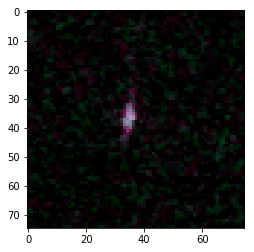

In [47]:
plt.imshow(X_train[0])
print(Y_train[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


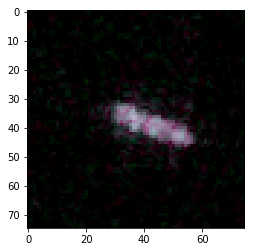

In [49]:
plt.imshow(X_train[100])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


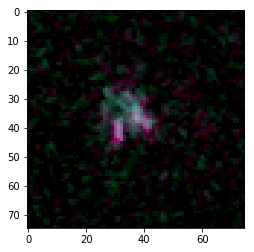

In [50]:
plt.imshow(X_train[50])
print(Y_train[50])

In [51]:
X_train.shape

(4113, 75, 75, 3)

In [52]:
Y_train.shape

(4113,)

# Creating the structure of Siamese Network

You just need to break it into some steps:
1. 2 Inputs for each images
2. Creating a network which both images will go through individually
3. Couple the network to each input
4. Calculate the L1 distance between them. Just (x1,y1)-(x2,y2)
5. 1 Added layer that will say 1 if they are the same and 0 if they are different

# Create two Inputs for each image - left_input and right_input
Hint - use Input Function in Keras and keep the shape to be 75,75,3

In [0]:
input_shape = (75,75,3)

In [0]:
left_input = Input(shape=(input_shape))
right_input = Input(shape=(input_shape))


# Create a base Network in which both images will go through individually.

Hint - Use Sequential Model in Keras with convolution layers, Maxpooling Layers, Flatten Layer and Denser Layer with appropriate activation functions.
Name the network as base_network

In [0]:
def create_base_network_signet(input_shape):
    '''Base Siamese Network'''
    
    seq = Sequential()
    seq.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape= input_shape))
    seq.add(BatchNormalization())
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))    
    seq.add(ZeroPadding2D((2, 2)))
    
    seq.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1'))
    seq.add(BatchNormalization())
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))
    seq.add(ZeroPadding2D((1, 1)))
    
    seq.add(Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1'))
    seq.add(ZeroPadding2D((1, 1)))
    
    seq.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_2'))    
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(1024, activation='relu'))
    seq.add(Dropout(0.5))
    
    seq.add(Dense(128, activation='relu')) # softmax changed to relu
    
    return seq

In [0]:
base_network = create_base_network_signet(input_shape)

# Process the left and right inputs to the same Base Network(base_network)

In [0]:
# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(left_input)
processed_b = base_network(right_input)

In [0]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [0]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [0]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    Source: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    
    Explanation:
    When ytrue is 1, that means the sample are duplicates of each other, 
    so the Euclidean distance (ypred) between their outputs must be minimized.
    So the loss is taken as the square of that Euclidean distance itself - K.square(y_pred).
    When ytrue is 0, i.e. the samples are not duplicates, then the Euclidean distance 
    between them must be maximized, at least to the margin. So the loss to be minimized
    is the difference of the margin and the Euclidean distance - (margin - y_pred).
    If the Euclidean distance (ypred) is already greater than the margin, 
    then nothing is to be learned, so the loss is made to be zero in 
    that case by saying K.maximum(margin - y_pred, 0).
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

# Get the L1 Distance layer between the 2 processed encodings (processed_a and processed_b)
Hint - You can use Lambda function for this.

In [0]:
# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

# Add the prediction layer in the end and create the Siamese Network using Model function.

In [62]:
model = Model(input=[left_input, right_input], output=distance)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("la...)`
  """Entry point for launching an IPython kernel.


# Define the Optimizer Adam and Compile the Siamese Model.

In [0]:
from keras.optimizers import Adam
# compile model using RMSProp Optimizer and Contrastive loss function defined above
adam = Adam(lr=1e-4, epsilon=1e-08)
model.compile(loss=contrastive_loss, optimizer=adam)

# Show the Summary of your Siamese Network

In [64]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 128)          2815488     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 1)            0           sequential_2[1][0]               
          

# Creating the Pair of Images to train on

It's not time to train though. We still have to create pairs of images to train on. There will be Positive(the same class) or Negative(different classes) for outputs. Let's construct this dataset. It is recommended that there are equal amounts positive and negative.

In [0]:
# First let's separate the dataset from 1 matrix to a list of matricies
image_list = np.split(X_train[:1000],1000)
label_list = np.split(Y_train[:1000],1000)

left_input = []
right_input = []
targets = []

#Number of pairs per image
pairs = 5
#Let's create the new dataset to train on
for i in range(len(label_list)):
    for _ in range(pairs):
        compare_to = i
        while compare_to == i: #Make sure it's not comparing to itself
            compare_to = random.randint(0,999)
        left_input.append(image_list[i])
        right_input.append(image_list[compare_to])
        if label_list[i] == label_list[compare_to]:# They are the same
            targets.append(1.)
        else:# Not the same
            targets.append(0.)
            
left_input = np.squeeze(np.array(left_input))
right_input = np.squeeze(np.array(right_input))
targets = np.squeeze(np.array(targets))



iceimage = X_train[101]
test_left = []
test_right = []
test_targets = []

for i in range(Y_train.shape[0]-1000):
    test_left.append(iceimage)
    test_right.append(X_train[i+1000])
    test_targets.append(Y_train[i+1000])

test_left = np.squeeze(np.array(test_left))
test_right = np.squeeze(np.array(test_right))
test_targets = np.squeeze(np.array(test_targets))

In [71]:
Y_train.shape[0]

4113

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


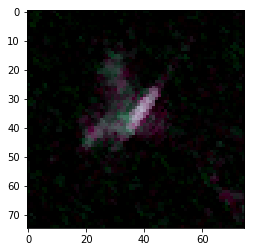

In [72]:
plt.imshow(X_train[101])

Now we have a lot more examples.
Now we have pairs x 1000 examples to train the network on. 
Each side will have an input of an image and the output will be one if they are the same and zero if not.

# Train the Siamese train on left and right input image pairs created and validate it by test pairs.

In [70]:
print(left_input.shape)
print(right_input.shape)
print(targets.shape)

(5000, 75, 75, 3)
(5000, 75, 75, 3)
(5000,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


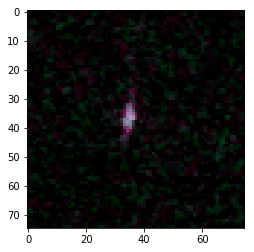

In [84]:
plt.imshow(left_input[3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


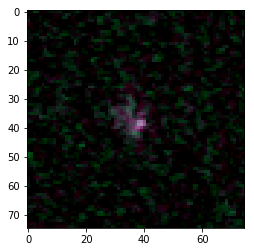

In [85]:
plt.imshow(right_input[3])

In [86]:
targets[3]

0.0

In [66]:
print(test_left.shape)
print(test_right.shape)
print(test_targets.shape)

(3113, 75, 75, 3)
(3113, 75, 75, 3)
(3113,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


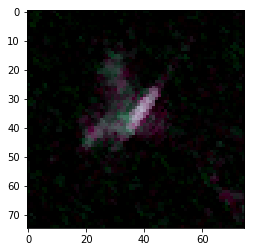

In [67]:
plt.imshow(test_left[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


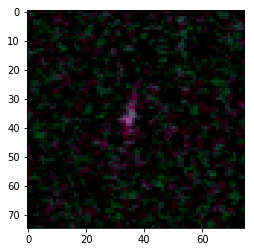

In [68]:
plt.imshow(test_right[0])

In [69]:
test_targets[0]

1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


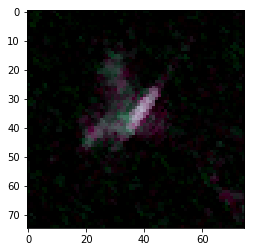

In [31]:
plt.imshow(test_left[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


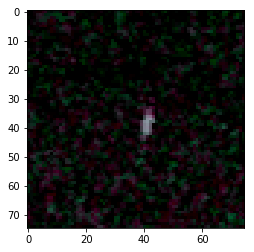

In [32]:
plt.imshow(test_right[1])

In [33]:
test_targets[1]

0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


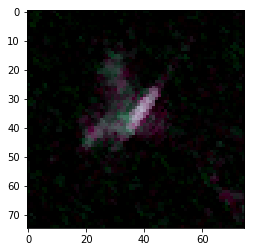

In [34]:
plt.imshow(test_left[2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


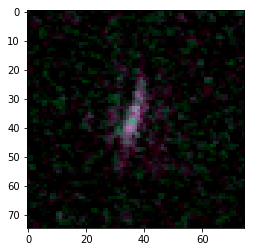

In [35]:
plt.imshow(test_right[2])

In [36]:
test_targets[2]

1

In [74]:
test_targets

array([1, 0, 1, ..., 0, 1, 0])

In [0]:
# Using Keras Callbacks, save the model after every epoch
# Reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs
# Stop the training using early stopping if the validation loss does not improve for 12 epochs
callbacks = [
    EarlyStopping(patience=12, verbose=1, monitor='val_loss',mode='auto'),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('./model.h5', verbose=1, save_weights_only=True, monitor='val_loss', mode='auto', save_best_only=True)
]

In [89]:
results = model.fit(x=[left_input,right_input], y=targets,epochs = 20,verbose=1,validation_data = ([test_left, test_right], test_targets))

Instructions for updating:
Use tf.cast instead.
Train on 5000 samples, validate on 3113 samples
Epoch 1/20
5000/5000 [==============================] - 7s 1ms/step - loss: 2.3153 - val_loss: 0.4440
Epoch 2/20
5000/5000 [==============================] - 4s 832us/step - loss: 0.2606 - val_loss: 0.4214
Epoch 3/20
5000/5000 [==============================] - 4s 835us/step - loss: 0.2590 - val_loss: 0.4339
Epoch 4/20
5000/5000 [==============================] - 4s 848us/step - loss: 0.2586 - val_loss: 0.4356
Epoch 5/20
5000/5000 [==============================] - 4s 883us/step - loss: 0.2564 - val_loss: 0.4260
Epoch 6/20
5000/5000 [==============================] - 4s 881us/step - loss: 0.2577 - val_loss: 0.4120
Epoch 7/20
5000/5000 [==============================] - 4s 841us/step - loss: 0.2586 - val_loss: 0.4535
Epoch 8/20
5000/5000 [==============================] - 4s 842us/step - loss: 0.2600 - val_loss: 0.4229
Epoch 9/20
5000/5000 [==============================] - 4s 843us/step - lo

In [91]:
results = model.fit(x=[left_input,right_input], y=targets,epochs = 20,verbose=1,validation_data = ([test_left, test_right], test_targets), callbacks=callbacks)

Train on 5000 samples, validate on 3113 samples
Epoch 1/20
5000/5000 [==============================] - 4s 870us/step - loss: 0.0540 - val_loss: 0.1456

Epoch 00001: saving model to ./model.h5
Epoch 2/20
5000/5000 [==============================] - 4s 838us/step - loss: 0.0371 - val_loss: 0.1542

Epoch 00002: saving model to ./model.h5
Epoch 3/20
5000/5000 [==============================] - 4s 838us/step - loss: 0.0349 - val_loss: 0.1540

Epoch 00003: saving model to ./model.h5
Epoch 4/20
5000/5000 [==============================] - 4s 865us/step - loss: 0.0270 - val_loss: 0.1600

Epoch 00004: saving model to ./model.h5
Epoch 5/20
5000/5000 [==============================] - 4s 865us/step - loss: 0.0240 - val_loss: 0.1525

Epoch 00005: saving model to ./model.h5
Epoch 6/20
5000/5000 [==============================] - 4s 844us/step - loss: 0.0188 - val_loss: 0.1540

Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00006: saving model to ./model.h5
E

In [94]:
results = model.fit(x=[left_input,right_input], y=targets,epochs = 20,verbose=1,validation_data = ([test_left, test_right], test_targets), callbacks=callbacks)

Train on 5000 samples, validate on 3113 samples
Epoch 1/20
5000/5000 [==============================] - 4s 899us/step - loss: 0.0165 - val_loss: 0.1512

Epoch 00001: saving model to ./model.h5
Epoch 2/20
5000/5000 [==============================] - 4s 853us/step - loss: 0.0154 - val_loss: 0.1515

Epoch 00002: saving model to ./model.h5
Epoch 3/20
5000/5000 [==============================] - 4s 821us/step - loss: 0.0159 - val_loss: 0.1508

Epoch 00003: saving model to ./model.h5
Epoch 4/20
5000/5000 [==============================] - 4s 832us/step - loss: 0.0161 - val_loss: 0.1521

Epoch 00004: saving model to ./model.h5
Epoch 5/20
5000/5000 [==============================] - 4s 824us/step - loss: 0.0159 - val_loss: 0.1522

Epoch 00005: saving model to ./model.h5
Epoch 6/20
5000/5000 [==============================] - 4s 818us/step - loss: 0.0159 - val_loss: 0.1520

Epoch 00006: saving model to ./model.h5
Epoch 7/20
5000/5000 [==============================] - 4s 822us/step - loss: 0.01

Train on 5000 samples, validate on 3113 samples
Epoch 1/20
5000/5000 [==============================] - 4s 870us/step - loss: 0.0152 - val_loss: 0.1521

Epoch 00001: val_loss improved from inf to 0.15214, saving model to ./model.h5
Epoch 2/20
5000/5000 [==============================] - 4s 834us/step - loss: 0.0151 - val_loss: 0.1524

Epoch 00002: val_loss did not improve from 0.15214
Epoch 3/20
5000/5000 [==============================] - 4s 828us/step - loss: 0.0152 - val_loss: 0.1533

Epoch 00003: val_loss did not improve from 0.15214
Epoch 4/20
5000/5000 [==============================] - 4s 823us/step - loss: 0.0154 - val_loss: 0.1533

Epoch 00004: val_loss did not improve from 0.15214
Epoch 5/20
5000/5000 [==============================] - 4s 828us/step - loss: 0.0147 - val_loss: 0.1545

Epoch 00005: val_loss did not improve from 0.15214
Epoch 6/20
5000/5000 [==============================] - 4s 830us/step - loss: 0.0151 - val_loss: 0.1523

Epoch 00006: val_loss did not improve f

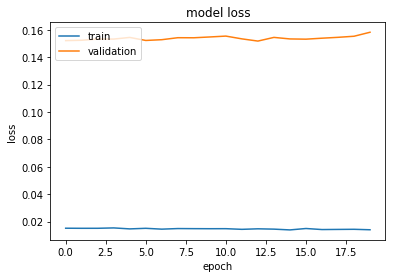

In [102]:
results = model.fit(x=[left_input,right_input], y=targets,epochs = 20,verbose=1,validation_data = ([test_left, test_right], test_targets), callbacks=callbacks)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
def compute_accuracy_roc(predictions, labels):
    '''Compute ROC accuracy with a range of thresholds on distances.
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)
   
    step = 0.01
    max_acc = 0
    best_thresh = -1
   
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d
       
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        acc = 0.5 * (tpr + tnr)       
#       print ('ROC', acc, tpr, tnr)
       
        if (acc > max_acc):
            max_acc, best_thresh = acc, d
           
    return max_acc, best_thresh

In [96]:
target_pred = model.predict([test_left, test_right])
target_pred

array([[0.        ],
       [0.57303035],
       [0.        ],
       ...,
       [0.872006  ],
       [0.        ],
       [0.845021  ]], dtype=float32)

In [104]:
accuracy, best_threshold = compute_accuracy_roc(target_pred, test_targets)
print(accuracy)
print(best_threshold)

0.823553919321899
0.72


Accuracy of 82% is achieved and the difference score is less than 0.72, then the imags are similar, otherwise, images are different

Checking the label of ice image

In [115]:
Y_train[101]

1

<h4>Comparision of predicted and actual images</h4>

<b>Comparing predicted and actual lables for 2nd image in the test set</b>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


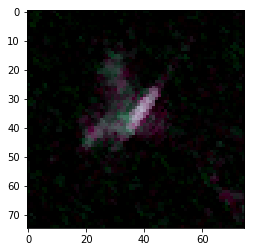

In [126]:
plt.imshow(test_left[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


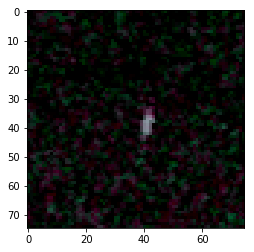

In [127]:
plt.imshow(test_right[1])

In [128]:
test_targets[1]

0

In [129]:
target_pred[1]

array([0.57303035], dtype=float32)

<u>Result</u>: Difference score is 0.57 which is less than 0.72 and hence predicted image is ice image, but actually it is not and the prediction is wrong here

<b>Comparing predicted and actual lables for 3rd image in the test set</b>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


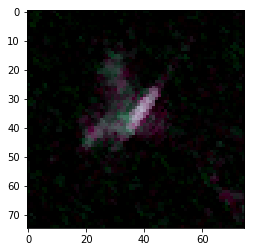

In [110]:
plt.imshow(test_left[2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


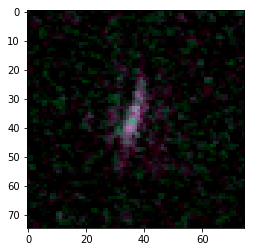

In [111]:
plt.imshow(test_right[2])

In [112]:
test_targets[2]

1

In [113]:
target_pred[2]

array([0.], dtype=float32)

<u>Result</u>:
Difference score is 0.0 and hence the test_right[2] is ice image

<b>Comparing predicted and actual lables for 3112th image in the test set</b>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


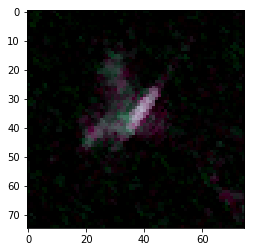

In [118]:
plt.imshow(test_left[3112])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


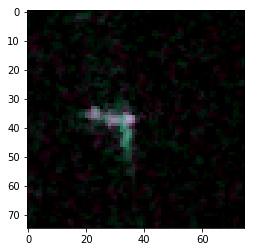

In [119]:
plt.imshow(test_right[3112])

In [124]:
test_targets[3112]

0

In [121]:
target_pred[3112]

array([0.845021], dtype=float32)

<u>Result</u>:
Difference score is 0.0 and hence the test_right[2] is ice image

<b>Comparing predicted and actual labels for 3110th image</b>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


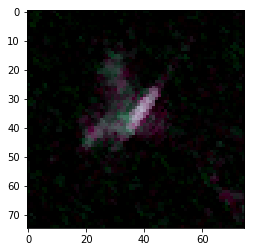

In [122]:
plt.imshow(test_left[3110])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


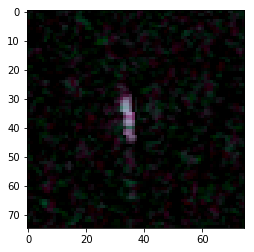

In [123]:
plt.imshow(test_right[3110])

In [125]:
test_targets[3110]

0

In [130]:
target_pred[3110]

array([0.872006], dtype=float32)

<u>Result</u>:
Difference score is 0.87 which is greater than threshold and hence the test_right[3110] is not ice image